In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams.update({'font.size': 12})
pylab.rcParams.update({'font.family': 'sans serif'})
pylab.rcParams.update({'mathtext.default':'regular'})
pylab.rcParams.update({'mathtext.fontset':'stixsans'})
pylab.rcParams.update({'axes.linewidth': 1.5})
pylab.rcParams.update({'xtick.direction':'in'})
pylab.rcParams.update({'xtick.major.size': 5})
pylab.rcParams.update({'xtick.major.width': 1.25 })
pylab.rcParams.update({'xtick.minor.size': 2.5})
pylab.rcParams.update({'xtick.minor.width': 1.25 })
pylab.rcParams.update({'ytick.direction':'in'})
pylab.rcParams.update({'ytick.major.size': 5})
pylab.rcParams.update({'ytick.major.width': 1.25 })
pylab.rcParams.update({'ytick.minor.size': 2.5})
pylab.rcParams.update({'ytick.minor.width': 1.25 })

import warnings
warnings.filterwarnings("ignore")

T_colors = ["lightskyblue", "violet", "forestgreen", "darkviolet", "thistle", "cadetblue", 
            "palegoldenrod", "darksalmon", "indigo"]

Populating the interactive namespace from numpy and matplotlib


In [2]:
# conversion functions that convert CGS units into simulation units
class SimUnitConverter:
    # conversion factors to get CGS units into Cholla units
    LENGTH_UNIT = 3.08567758e21; # kpc in cm
    MASS_UNIT = 1.98855e33; # solar mass in grams
    TIME_UNIT = 3.15569e10; # kyr in s
    DENSITY_UNIT = (MASS_UNIT/(LENGTH_UNIT*LENGTH_UNIT*LENGTH_UNIT)); 
    VELOCITY_UNIT = (LENGTH_UNIT/TIME_UNIT);
    PRESSURE_UNIT = (DENSITY_UNIT*VELOCITY_UNIT*VELOCITY_UNIT);
    
    def density(self, d_cgs):
        # convert g/cm^3 to M_sun/kpc^3
        return d_cgs * self.LENGTH_UNIT ** 3 / self.MASS_UNIT
    
    def mass(self, m_cgs):
        # convert g to M_sun
        return m_cgs / self.MASS_UNIT
    
    def time(self, t_cgs):
        # convert s to kyr
        return t_cgs / self.TIME_UNIT
    
    def length(self, l_cgs):
        # convert cm to kpc
        return l_cgs / self.LENGTH_UNIT
    
    def velocity(self, v_cgs):
        # convert cm/s to kpc/kyr
        return v_cgs / self.VELOCITY_UNIT

    def pressure(self, p_cgs):
        # convert g*cm^-1*s^-2 to M_sun*kpc^-1*kyr^-2
        return p_cgs / self.PRESSURE_UNIT

In [14]:
class DustIntegrator:
    MP = 1.6726E-24;  # proton mass in g
    YR_IN_S = 3.154e7 # one year in s
    # use this ^ conversion just because it's easier to think about time in terms of years
    
    # solar abundances (percentage of total mass)
    # O, C, N, Si, Mg, Ne, Fe, S
    metals = np.array([0.0097, 0.0040, 0.00096, 0.00099, 0.00076, 0.00058, 0.0014, 0.00040]);
    metallicity = np.sum(metals)
    
    def __init__(self, T, n, dt, tmax):
        self.T = T # K
        self.n = n
        self.dt = dt # passed in in s
        self.tmax = tmax # passed in in s
        self._d0_gas, self._d0_metal, self._d0_dust = self.calc_init_density() # g/cm^3
        self.d_gas, self.d_metal, self.d_dust = self.calc_init_density() # g/cm^3
        self.tau_g = self.calc_tau_g() # s
        self.tau_sp = self.calc_tau_sp() # s
        self.type = "tot_dust_density"

    def calc_tau_g(self):
        tau_g_ref = 0.2e9 * self.YR_IN_S # 0.2 Gyr in s
        d_ref = self.MP # 1 H atom per cubic centimer
        T_ref = 20.0; # 20 K
        tau_g = tau_g_ref * (d_ref/(self._d0_gas)) * (T_ref/self.T) ** (1/2); # s
    
        return tau_g
    
    def calc_tau_sp(self):
        a1 = 3; # dust grain size in units of 1 micrometer
        d0 = 1; # gas density in units of 10^-27 g/cm^3
        T_0 = 2e6; # K
        omega = 2.5;
        A = 0.17e9 * self.YR_IN_S; # 0.17 Gyr in s
        
        tau_sp = A * (a1/d0) * ((T_0/self.T) ** omega + 1); # s
        
        return tau_sp
    
    def calc_init_density(self):
        d0_gas = self.MP * self.n # g/cm^3
        d0_metal = self.metallicity * d0_gas
        # assume 1% dust to gas fraction
        d0_dust = d0_gas / 100
        
        return d0_gas, d0_metal, d0_dust
    
    """
    def calc_dd_dt(self):
        # calculate the rate of change of dust density
        # accretion term + sputtering term
        # g/cm^3/s
        dd_dt = (1 - self.d_dust/self.d_metal)*(self.d_dust/self.tau_g) - self.d_dust/(self.tau_sp/3)
        
        return dd_dt
    """

    def calc_dd_dt(self):
        # calculate the rate of change of dust density
        # accretion term + sputtering term
        # g/cm^3/s
        dd_dt = (1 - self.d_dust/self.d_metal)*(self.d_dust/self.tau_g)
        
        return dd_dt
    
    def calc_d_dust(self):
        # calculate the new total dust density
        dd_dt = self.calc_dd_dt()
        d_dust_i = self.d_dust + self.dt * dd_dt
        
        return d_dust_i
    
    def update_densities(self):
        # update the integrator's density attributes
        dd_dt = self.calc_dd_dt()
        self.d_dust += self.dt * dd_dt
        self.d_metal -= self.dt * dd_dt
    
    def get_info(self):
        print("Gas temperature: {:.1E} K".format(self.T))
        print("Gas initial mass density: {:.5E} g/cm^3".format(self._d0_gas))
        print("Gas initial number density: {} cm^-3".format(self.n))
        print("Growth timescale: {:.5E} yr".format(self.tau_g/self.YR_IN_S))
        print("Destruction timescale: {:.5E} yr".format(self.tau_sp/self.YR_IN_S))
        print("Time-step: {} yr".format(self.dt/self.YR_IN_S))
        print("------------------------------------------")

In [4]:
def evolve_solutions(h, n, T_arr, tmax):
    YEAR_IN_SECONDS = 3.154e7
    h *= YEAR_IN_SECONDS
    tmax *= YEAR_IN_SECONDS
    
    t_arr = np.arange(0, tmax, h)
    
    d_dust = np.zeros(shape=(len(T_arr), len(t_arr)))
    d_metal = np.zeros(shape=(len(T_arr), len(t_arr)))

    integrators = []
    
    taus = []
    
    def time_refine(integrator):
        """Refine time-step if dd is changing too rapidly."""
        d_dust_i = integrator.calc_d_dust()
        dd_dt = integrator.calc_dd_dt()
        dt = integrator.dt
        dd = dd_dt * dt
        while dd/d_dust_i > 0.01:
            dt_sub = 0.01 * d_dust_i / dd_dt

            integrator.d_dust += dt_sub * dd_dt
            integrator.d_metal -= dt_sub * dd_dt
            integrator.dt -= dt_sub
            dt = integrator.dt
            dd_dt = integrator.calc_dd_dt()
            dd = dt * dd_dt

    for j, T in enumerate(T_arr):
        integrator = DustIntegrator(T, n, h, tmax)
        integrator.get_info()
        # set initial densities
        d_dust[j][0] = integrator._d0_dust
        taus.append(integrator.tau_g) # s
        integrators.append(integrator)

        for i, t_i in enumerate(t_arr):
            if (i+1) < len(t_arr):
                for integrator in integrators:
                    # calculate dust density for this time-step
                    d_dust_i = integrator.calc_d_dust()
                    # calculate dd
                    dd_dt = integrator.calc_dd_dt()
                    dd = integrator.dt * dd_dt

                    # if rate of dust growth is changing too rapidly
                    if dd/d_dust_i > 0.01:
                        # shorten time-step
                        time_refine(integrator)
                        integrator.dt = h
                        d_dust[j][i+1] = integrator.d_dust
                        d_metal[j][i+1] = integrator.d_metal
                        continue

                    # this is where the density attribute gets updated
                    integrator.update_densities()
                    d_dust[j][i+1] = integrator.d_dust
                    d_metal[j][i+1] = integrator.d_metal

    return d_dust, d_metal, taus, integrators

In [5]:
dd, dm, tau_gs, integrators = evolve_solutions(1e3, 1e-2, [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8], 1e9)

Gas temperature: 1.0E+01 K
Gas initial mass density: 1.67260E-26 g/cm^3
Gas initial number density: 0.01 cm^-3
Growth timescale: 2.82843E+10 yr
Destruction timescale: 9.12316E+21 yr
Time-step: 1000.0 yr
------------------------------------------
Gas temperature: 1.0E+02 K
Gas initial mass density: 1.67260E-26 g/cm^3
Gas initial number density: 0.01 cm^-3
Growth timescale: 8.94427E+09 yr
Destruction timescale: 2.88500E+19 yr
Time-step: 1000.0 yr
------------------------------------------
Gas temperature: 1.0E+03 K
Gas initial mass density: 1.67260E-26 g/cm^3
Gas initial number density: 0.01 cm^-3
Growth timescale: 2.82843E+09 yr
Destruction timescale: 9.12316E+16 yr
Time-step: 1000.0 yr
------------------------------------------
Gas temperature: 1.0E+04 K
Gas initial mass density: 1.67260E-26 g/cm^3
Gas initial number density: 0.01 cm^-3
Growth timescale: 8.94427E+08 yr
Destruction timescale: 2.88500E+14 yr
Time-step: 1000.0 yr
------------------------------------------
Gas temperature:

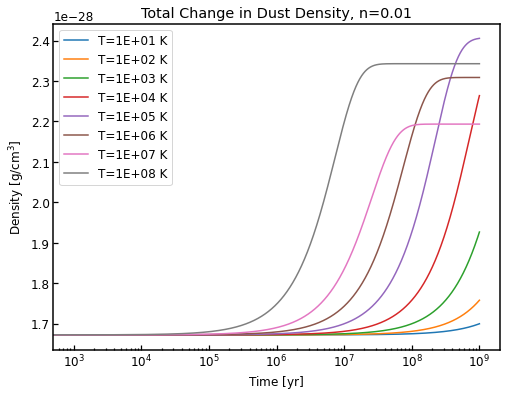

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))
for i, dd_i in enumerate(dd):
    ax.semilogx(np.arange(0, integrators[i].tmax/integrators[i].YR_IN_S, integrators[i].dt/integrators[i].YR_IN_S), dd_i, label=f"T={integrators[i].T:.0E} K")
    #ax.vlines(tau_gs[i], ymin=np.amin(dd_i), ymax=np.amax(dd_i), color="k", linestyle="--", zorder=0)
    ax.set_xlabel("Time$~[yr]$")
    ax.set_ylabel(r"Density$~[g/cm^3]$")
    ax.set_title(f"Total Change in Dust Density, n={integrators[i].n}")
    ax.legend()

In [7]:
dd, dm, tau_gs, integrators = evolve_solutions(1e3, 1e-1, [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8], 1e7)

Gas temperature: 1.0E+01 K
Gas initial mass density: 1.67260E-25 g/cm^3
Gas initial number density: 0.1 cm^-3
Growth timescale: 2.82843E+09 yr
Destruction timescale: 9.12316E+21 yr
Time-step: 1000.0 yr
------------------------------------------
Gas temperature: 1.0E+02 K
Gas initial mass density: 1.67260E-25 g/cm^3
Gas initial number density: 0.1 cm^-3
Growth timescale: 8.94427E+08 yr
Destruction timescale: 2.88500E+19 yr
Time-step: 1000.0 yr
------------------------------------------
Gas temperature: 1.0E+03 K
Gas initial mass density: 1.67260E-25 g/cm^3
Gas initial number density: 0.1 cm^-3
Growth timescale: 2.82843E+08 yr
Destruction timescale: 9.12316E+16 yr
Time-step: 1000.0 yr
------------------------------------------
Gas temperature: 1.0E+04 K
Gas initial mass density: 1.67260E-25 g/cm^3
Gas initial number density: 0.1 cm^-3
Growth timescale: 8.94427E+07 yr
Destruction timescale: 2.88500E+14 yr
Time-step: 1000.0 yr
------------------------------------------
Gas temperature: 1.0

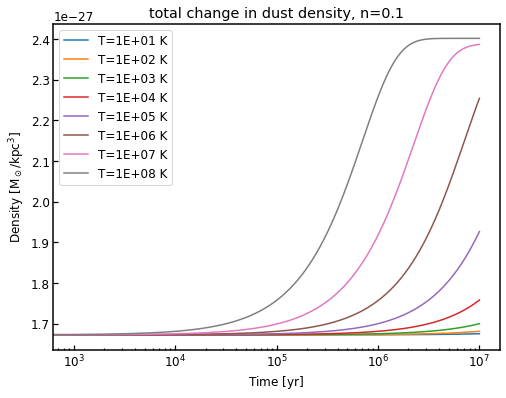

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))
for i, dd_i in enumerate(dd):
    ax.semilogx(np.arange(0, integrators[i].tmax/integrators[i].YR_IN_S, integrators[i].dt/integrators[i].YR_IN_S), dd_i, label=f"T={integrators[i].T:.0E} K")
    #ax.vlines(tau_gs[i], ymin=np.amin(dd_i), ymax=np.amax(dd_i), color="k", linestyle="--", zorder=0)
    ax.set_xlabel("Time$~[yr]$")
    ax.set_ylabel(r"Density$~[M_\odot/kpc^3]$")
    ax.set_title(f"total change in dust density, n={integrators[i].n}")
    ax.legend()

In [9]:
dd, dm, tau_gs, integrators = evolve_solutions(1e3, 1, [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8], 1e7)

Gas temperature: 1.0E+01 K
Gas initial mass density: 1.67260E-24 g/cm^3
Gas initial number density: 1 cm^-3
Growth timescale: 2.82843E+08 yr
Destruction timescale: 9.12316E+21 yr
Time-step: 1000.0 yr
------------------------------------------
Gas temperature: 1.0E+02 K
Gas initial mass density: 1.67260E-24 g/cm^3
Gas initial number density: 1 cm^-3
Growth timescale: 8.94427E+07 yr
Destruction timescale: 2.88500E+19 yr
Time-step: 1000.0 yr
------------------------------------------
Gas temperature: 1.0E+03 K
Gas initial mass density: 1.67260E-24 g/cm^3
Gas initial number density: 1 cm^-3
Growth timescale: 2.82843E+07 yr
Destruction timescale: 9.12316E+16 yr
Time-step: 1000.0 yr
------------------------------------------
Gas temperature: 1.0E+04 K
Gas initial mass density: 1.67260E-24 g/cm^3
Gas initial number density: 1 cm^-3
Growth timescale: 8.94427E+06 yr
Destruction timescale: 2.88500E+14 yr
Time-step: 1000.0 yr
------------------------------------------
Gas temperature: 1.0E+05 K
G

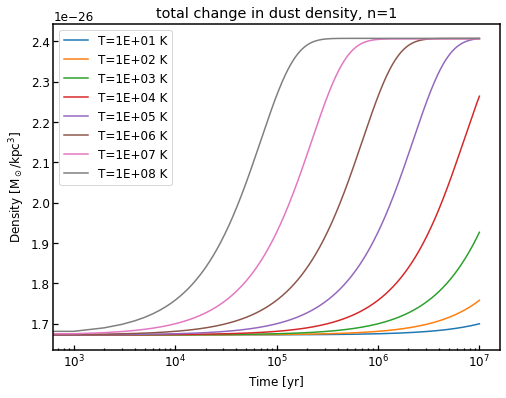

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))
for i, dd_i in enumerate(dd):
    ax.semilogx(np.arange(0, integrators[i].tmax/integrators[i].YR_IN_S, integrators[i].dt/integrators[i].YR_IN_S), dd_i, label=f"T={integrators[i].T:.0E} K")
    #ax.vlines(tau_gs[i], ymin=np.amin(dd_i), ymax=np.amax(dd_i), color="k", linestyle="--", zorder=0)
    ax.set_xlabel("Time$~[yr]$")
    ax.set_ylabel(r"Density$~[M_\odot/kpc^3]$")
    ax.set_title(f"total change in dust density, n={integrators[i].n}")
    ax.legend()

In [19]:
dd, dm, tau_gs, integrators = evolve_solutions(1e2, 1e0, [20], 1e8)

Gas temperature: 2.0E+01 K
Gas initial mass density: 1.67260E-24 g/cm^3
Gas initial number density: 1.0 cm^-3
Growth timescale: 2.00000E+08 yr
Destruction timescale: 1.61276E+21 yr
Time-step: 100.0 yr
------------------------------------------


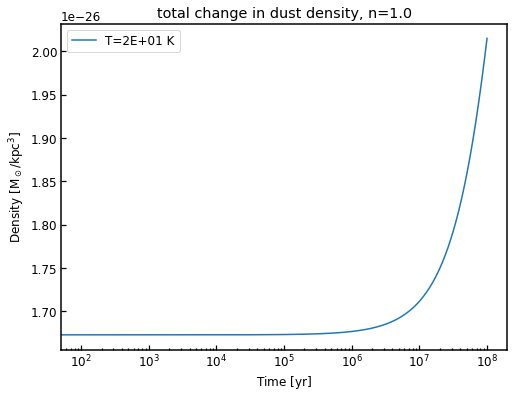

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))
for i, dd_i in enumerate(dd):
    ax.semilogx(np.arange(0, integrators[i].tmax/integrators[i].YR_IN_S, integrators[i].dt/integrators[i].YR_IN_S), dd_i, label=f"T={integrators[i].T:.0E} K")
    #ax.vlines(tau_gs[i], ymin=np.amin(dd_i), ymax=np.amax(dd_i), color="k", linestyle="--", zorder=0)
    ax.set_xlabel("Time$~[yr]$")
    ax.set_ylabel(r"Density$~[M_\odot/kpc^3]$")
    ax.set_title(f"total change in dust density, n={integrators[i].n}")
    ax.legend()